# Nota Importante
O propósito deste notebook é encontrar o melhor modelo para os dados Sem Outliers, mantendo a simplicidade do LinearRegression.

Vamos usar diferentes opções de transformação de target para encontrar o melhor.

Nesta etapa, ainda não vamos nos preocupar com regularização de coeficiente nem com features polinomais. Faremos isso em etapas posteriores.

---

Leia o arquivo [README.md](../README.md) para detalhes sobre a base o projeto.

Leia o arquivo de [01_dicionario_de_dados.md](../referencias/01_dicionario_de_dados.md) para detalhes sobre a base.

Ao importar esse arquivo [src.graficos](./src/graficos.py), em tema seaborn é aplicado.

# Imports e configurações

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
import seaborn as sns

from sklearn.compose import ColumnTransformer # constrói um pipeline para diferentes colunas
from sklearn.linear_model import (
    LinearRegression, # modelo de regressão linear com coeficientes estimados usando o método dos mínimos quadrados
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import ( # pré-processamento de dados
    OrdinalEncoder, # codifica variáveis categóricas com ordenação para valores inteiros
    OneHotEncoder, # codifica variáveis categóricas sem ordenação para uma matriz binária
    PowerTransformer, # aplica uma transformação de potência para estabilizar a variância
    QuantileTransformer, # aplica transformação baseado em quantis
)


from src.auxiliares import (
    fnc_dataframe_coeficientes,
    fnc_describe_numericas_personalizado,
    fnc_exibir_dataframe_resultados,
)
from src.config import (
    DADOS_LIMPOS,
    DADOS_X_TEST,
    DADOS_X_TRAIN,
    DADOS_X_VALIDATION,
    DADOS_Y_TEST,
    DADOS_Y_TRAIN,
    DADOS_Y_VALIDATION,
    RANDOM_STATE,
)
from src.graficos import (
    PALETTE_TEMPERATURA,
    plot_coeficientes, # função para plotar um gráfico de barras horizontais dos coeficientes de um modelo
    plot_comparar_metricas_modelos, # função para plotar boxplots de diferentes modelos para diferentes méticas de um dataframe de resultado
    plot_residuos_estimador, # função que plota 3 gráficos de resíduos para um estimador, um histograma e dois de dispersão
)
from src.models import (
    fnc_grid_search_cv_regressor, # função para planejar modelos de regressão validação cruzada e grid search
    fnc_treinar_e_validar_modelos_regressao, # função para treinar modelos de regressão com validação cruzada usando um dicionário de regressores
)

In [2]:
pd.options.display.max_rows = 15
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format

# Modelagem inicial - Sem Outliers

É a mesma da etapa 1, repetindo apenas para ser usada na comparação com as demais transformações.

Não usaremos mais a DummyRegressor, uma vez que já sabemos que nossos dados permitem um modelo melhor que a média pela análise da epata 1.

## Carregando o arquivo completo - Com outliers

Origem: [01-ild-eda.ipynb](01-ild-eda.ipynb)

- `median_income`: renda mediana no grupo de blocos (em dezenas de milhares de dólares)
- `housing_median_age`: idade mediana das casas no grupo de blocos
- `total_rooms`: número cômodos no grupo de blocos
- `total_bedrooms`: número de quartos no grupo de blocos
- `population`: população do grupo de blocos
- `households`: domicílios no grupo de blocos
- `latitude`: latitude do grupo de blocos
- `longitude`: longitude do grupo de blocos
- `ocean_proximity`: proximidade do oceano
  - `NEAR BAY`: perto da baía
  - `<1H OCEAN`: a menos de uma hora do oceano
  - `INLAND`: no interior
  - `NEAR OCEAN`: perto do oceano
- `median_house_value`: valor mediano das casas no grupo de blocos (em dólares)
- `median_income_cat`: categorias baseadas no valor da mediana do salário anual -> `median_income`
- `housing_median_age_cat`: categorias baseadas no valor da mediana das idades das casas -> `housing_median_age`
- `population_cat`: categorias baseadas no tamanho da população -> `population`
- `rooms_per_household`: `total_rooms` / `households`
- `population_per_household`: `population` / `households`
- `bedrooms_per_room`: `total_bedrooms` / `total_rooms`

In [3]:
# dados completos são os dados sem outliers
df = pd.read_parquet(DADOS_LIMPOS)

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.33,452600,NEAR BAY,6 <= x,40 <= x,0 <= x < 500,6.98,2.56,0.15
1,-122.22,37.86,21,7099,1106,2401,1138,8.30,358500,NEAR BAY,6 <= x,20 <= x < 30,2000 <= x,6.24,2.11,0.16
2,-122.26,37.84,42,2555,665,1206,595,2.08,226700,NEAR BAY,1.5 <= x < 3,40 <= x,1000 <= x < 1500,4.29,2.03,0.26
3,-122.26,37.85,50,1120,283,697,264,2.12,140000,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,4.24,2.64,0.25
4,-122.26,37.84,50,2239,455,990,419,1.99,158700,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,5.34,2.36,0.20


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18375 entries, 0 to 18374
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 18375 non-null  float32 
 1   latitude                  18375 non-null  float32 
 2   housing_median_age        18375 non-null  uint8   
 3   total_rooms               18375 non-null  uint16  
 4   total_bedrooms            18375 non-null  uint16  
 5   population                18375 non-null  uint16  
 6   households                18375 non-null  uint16  
 7   median_income             18375 non-null  float32 
 8   median_house_value        18375 non-null  uint32  
 9   ocean_proximity           18375 non-null  category
 10  median_income_cat         18375 non-null  category
 11  housing_median_age_cat    18375 non-null  category
 12  population_cat            18375 non-null  category
 13  rooms_per_household       18375 non-null  floa

## Definindo as estratégias para os modelos

In [6]:
coluna_target = ['median_house_value']

# define as colunas a serem transformadas 
colunas_one_hot_encoder = ['ocean_proximity',]
colunas_ordinal_encoder = ['median_income_cat', 'housing_median_age_cat', 'population_cat',]


# define o preprocessamento das colunas - o preprocessamento é feito em ordem
preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), colunas_one_hot_encoder), # drop='first' para evitar a dummy variable trap
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), colunas_ordinal_encoder), # categories='auto' para usar as categorias do dataframe
    ],
    remainder='passthrough', # mantém as colunas que não foram transformadas
)

# define a transformação da variável target - a transformação é feita para estabilizar a variância
target_transformer = PowerTransformer()

# define os modelos a serem testados - cada modelo é um dicionário com as chaves 'preprocessor', 'regressor' e 'target_transformer'
regressors = {
    'LinearRegression': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
    'LinearRegression_target': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': target_transformer,
    },
}


# algorítmos de avaliação de modelos de regressão a utilizar nessa análise - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
dct_metricas_modelos = {
        # 'd2_absolute_error_score'            : 'd2ae',  # melhor = 1.0 -> metrics.d2_absolute_error_score
        # 'explained_variance'                 : 'evs',   # melhor = 1.0 -> metrics.explained_variance_score
        # 'neg_max_error'                      : 'maxe',  # melhor = 0.0 -> metrics.max_error
        'neg_mean_absolute_error'            : 'mae',   # melhor = 0.0 -> metrics.mean_absolute_error
        # 'neg_mean_absolute_percentage_error' : 'mape',  # melhor = 0.0 -> metrics.mean_absolute_percentage_error
        # 'neg_mean_gamma_deviance'            : 'mgd',   # melhor = 0.0 -> metrics.mean_gamma_deviance
        # 'neg_mean_poisson_deviance'          : 'mpd',   # melhor = 0.0 -> metrics.mean_poisson_deviance
        # 'neg_mean_squared_error'             : 'mse',   # melhor = 0.0 -> metrics.mean_squared_error
        # 'neg_mean_squared_log_error'         : 'msle',  # melhor = 0.0 -> metrics.mean_squared_log_error
        # 'neg_median_absolute_error'          : 'medae', # melhor = 0.0 -> metrics.median_absolute_error
        'neg_root_mean_squared_error'        : 'rmse',  # melhor = 0.0 -> metrics.root_mean_squared_error
        # 'neg_root_mean_squared_log_error'    : 'rmsle', # melhor = 0.0 -> metrics.root_mean_squared_log_error
        'r2'                                 : 'r2',    # melhor = 1.0 -> metrics.r2_score
}


refit = 'neg_root_mean_squared_error' # algorítmos de avaliação de modelos de regressão que será usado como avaliador do melhor modelo


## Separando em treino, teste e validação
Como vamos usar o cross_validate que já separa em treino e teste diversas vezes, vamos apenas separa 10% para validação posterior.
Esses dados de validação não serão apesentados para o treinamento e servirão na análie de resíduos no final.

In [7]:
# Separar os dados em conjunto de treinamento/teste e validação.
X_train, X_test_validation, y_train, y_test_validation = train_test_split(
    df.drop(columns=coluna_target),
    df[coluna_target],
    test_size=0.3, # 70% para treino
    random_state=RANDOM_STATE,
)

display(X_train.shape)
display(X_train.head(1), y_train.head(1))

(12862, 15)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
4816,-118.28,33.91,41,620,133,642,162,2.65,<1H OCEAN,1.5 <= x < 3,40 <= x,500 <= x < 1000,3.83,3.96,0.21


,median_house_value
4816,159600


In [8]:
X_test = X_test_validation.sample(
    frac=0.66, # 20% para teste
    random_state=RANDOM_STATE,
)
y_test = y_test_validation.loc[X_test.index]

display(X_test.shape)
display(X_test.head(1), y_test.head(1))

(3639, 15)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
13191,-117.19,32.77,9,634,152,248,133,3.86,NEAR OCEAN,3 <= x < 4.5,0 <= x < 10,0 <= x < 500,4.77,1.86,0.24


,median_house_value
13191,143800


In [9]:
X_validation = X_test_validation.drop(X_test.index)
y_validation = y_test_validation.drop(X_test.index)

display(X_validation.shape)
display(X_validation.head(1), y_validation.head(1))

(1874, 15)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
15596,-121.95,37.26,10,3611,803,1599,716,5.20,<1H OCEAN,4.5 <= x < 6,10 <= x < 20,1500 <= x < 2000,5.04,2.23,0.22


,median_house_value
15596,248700


In [10]:
# salvando para uso nas futuras etapas, garantindo que sempre usaremos os mesmos dados para treinamento/teste e validação.
X_train.to_parquet(DADOS_X_TRAIN, index=True)
X_test.to_parquet(DADOS_X_TEST, index=True)
X_validation.to_parquet(DADOS_X_VALIDATION, index=True)

y_train.to_parquet(DADOS_Y_TRAIN, index=True)
y_test.to_parquet(DADOS_Y_TEST, index=True)
y_validation.to_parquet(DADOS_Y_VALIDATION, index=True)

## Treinando e avaliando os modelos conforme a estratégia definida acima

In [11]:
df_resultados = fnc_treinar_e_validar_modelos_regressao(
    X=X_train,
    y=y_train,
    regressors=regressors,
    scoring=tuple(dct_metricas_modelos.keys()),
)

fnc_exibir_dataframe_resultados(df_resultados)

Index(['model', 'fit_time', 'score_time', 'test_neg_mean_absolute_error',
       'test_neg_root_mean_squared_error', 'test_r2', 'time_seconds'],
      dtype='object')


,model,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
0,LinearRegression,0.031490,0.012580,-40752.245328,-55293.325335,0.649683,0.044070
1,LinearRegression,0.029084,0.013223,-43153.132860,-65273.979368,0.537121,0.042307
2,LinearRegression,0.027896,0.013290,-42344.177226,-58983.680481,0.625750,0.041186
3,LinearRegression,0.028228,0.013788,-42839.980813,-58944.889944,0.635304,0.042016
4,LinearRegression,0.026959,0.013388,-42373.880720,-58053.346421,0.625479,0.040347
5,LinearRegression_target,0.043548,0.014247,-39326.048236,-55245.090484,0.650294,0.057795
6,LinearRegression_target,0.048748,0.014289,-41013.808006,-59193.301841,0.619345,0.063038
7,LinearRegression_target,0.044538,0.013921,-40619.080220,-57187.468955,0.648196,0.058459
8,LinearRegression_target,0.043256,0.014287,-41644.359736,-59744.825687,0.625338,0.057543
9,LinearRegression_target,0.045435,0.014477,-41093.437180,-58493.375865,0.619780,0.059912


In [12]:
fnc_exibir_dataframe_resultados(df_resultados.groupby('model').mean())

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
model,,,,,,
LinearRegression,0.028731,0.013254,-42292.683389,-59309.844310,0.614667,0.041985
LinearRegression_target,0.045105,0.014244,-40739.346676,-57972.812567,0.632590,0.059349


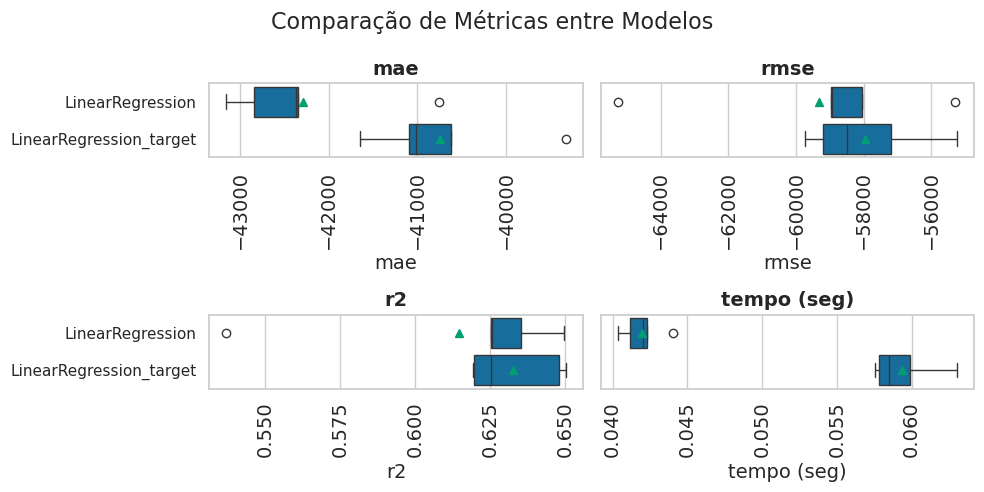

In [13]:
plot_comparar_metricas_modelos(
    df_resultados=df_resultados,
    comparar_metricas=['test_' + metrica for metrica in dct_metricas_modelos.keys()] + ['time_seconds'],
    nomes_metricas=list(dct_metricas_modelos.values()) + ['tempo (seg)'],
    figsize=(10, 5),
    colunas_graficos=2,
    flg_boxplots_horizontais=True,
)

### Considerações sobre o modelo inicial
- Agora, usando apenas dados de treino, podemos dizer que é melhor trabalharmos com a transformação de target;
- Vemos no gráfico e resultados acima que somente o no `r2` não temos mediana melhor para a transformação de target;
- A média é melhor em todas as métricas usando transformação de target.

A seguir, vamos fazer experimentos e comparar com os modelos que já conhecemos.

# Transformação de target
Experimentando uma mudança no algorítimo de transformação de target.

A estratégia anterior ainda faz parte dos experimentos.

## Estratégia de Grid Search para a transformação de target

In [14]:
# essa nova estratégia será somada à estratégia já conhecida na parte de target.
# lembrando que muitos cenários e muitos registros podem levar à lentidão no processamento.
param_grid = {
    'transformer': [
        None, # cenário sem mudança - já temos esse cenário atualmente
        PowerTransformer(method='yeo-johnson'), # cenário com mudança de PowerTransformer('yeo-johnson') - é o padrão, então também já temos
        PowerTransformer(method='box-cox'), # novo cenário
        QuantileTransformer(output_distribution='uniform'), # novo cenário
        QuantileTransformer(output_distribution='normal'), # novo cenário
    ]
}

## Construindo o plano de execução com as novas estratégias/cenários

In [15]:
grid_search = fnc_grid_search_cv_regressor(
    preprocessor=preprocessamento,
    regressor=LinearRegression(),
    target_transformer=target_transformer,
    param_grid=param_grid,
    scoring=tuple(dct_metricas_modelos.keys()),
    refit = refit,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=255, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat',
                                                                                                               'housing_median_age_cat',
                                                                                                               'populati...
                                                                            ('regressor',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-2,
             param_grid={'transformer': [None, PowerTransformer(),
                                         PowerTransformer(method='box-cox'),
                                         QuantileTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=('neg_mean_absolute_error', 'neg_root_mean_squared_error',
                      'r2'),
             verbose=1)

## Treinando e avaliando os modelos de acordo com o plano construído acima
Nesse etapa conseguimos saber quais são os melhores hiperparametros que entregaram o melhor modelo

In [16]:
grid_search.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/dados/app/conda/envs/california/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/dados/app/conda/envs/california/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/dados/app/conda/envs/california/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/dados/app/conda/envs/california/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/dados/app/conda/envs/california/lib/python3.12/site-packages/sklearn/metrics/_regression.py",

GridSearchCV(cv=KFold(n_splits=5, random_state=255, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat',
                                                                                                               'housing_median_age_cat',
                                                                                                               'populati...
                                                                            ('regressor',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-2,
             param_grid={'transformer': [None, PowerTransformer(),
                                         PowerTransformer(method='box-cox'),
                                         QuantileTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=('neg_mean_absolute_error', 'neg_root_mean_squared_error',
                      'r2'),
             verbose=1)

In [17]:
# informa os melhores parametros encontrados pelo GRID SEARCH
# no nosso caso, só planejamos a busca na transformação de target
grid_search.best_params_

{'transformer': QuantileTransformer(output_distribution='normal')}

In [18]:
# se refere à metrica escolhida para comparação na variável 'refit' da estratégia do GRID SEARCH
grid_search.best_score_

-57087.798096764294

### Sobre o melhor modelo
- vemos que foram 25 jobs/fits/processamentos, pois foram 5 parametros para a transformação de target e 5 validações cruzadas [o default da função em `n_splits`];
- A melhor transformação de target, após o treino foi a `QuantileTransformer(output_distribution='normal')`, que foi o ultimo cenário que configuramos/planejamos;
- Lembrando que considerando o `RMSE` como validador, que na versão original, tinha vencido na média e mediana a versão sem transformação de target;

Tivemos então uma melhoria do modelo usando `QuantileTransformer(output_distribution='normal')` considerando `RMSE`. Podemos avaliar esse modelo antes de partir para mais transformações.

## Avaliando o melhor modelo criado

In [19]:
# se esse numero for muito grande, melhor apresentar num dataframe vertical
# por causa das configurações de pandas feitas no inicio
len(grid_search.best_estimator_.regressor_['regressor'].coef_)

17

In [20]:
df_coeficientes = fnc_dataframe_coeficientes(
    colunas      = grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
    coeficientes = grid_search.best_estimator_.regressor_['regressor'].coef_,
    flg_mostrar_dataframe=True,
    flg_horizontal=True,
)

,remainder__bedrooms_per_room,one_hot__ocean_proximity_INLAND,remainder__median_income,remainder__longitude,remainder__latitude,one_hot__ocean_proximity_NEAR BAY,ordinal_encoder__median_income_cat,remainder__rooms_per_household,one_hot__ocean_proximity_NEAR OCEAN,ordinal_encoder__housing_median_age_cat,remainder__housing_median_age,remainder__population_per_household,remainder__households,remainder__population,remainder__total_bedrooms,ordinal_encoder__population_cat,remainder__total_rooms
coeficiente,2.352248,-0.513446,0.375588,-0.266224,-0.247976,-0.174192,0.052518,0.032278,-0.013985,0.013460,0.003179,-0.001119,0.000861,-0.000280,0.000255,0.000253,-0.000030


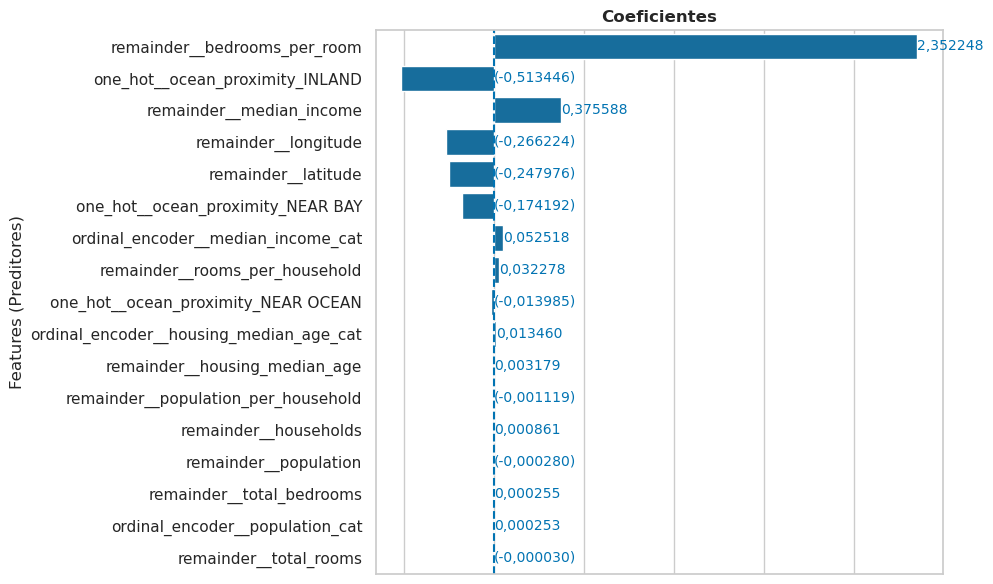

In [21]:
plot_coeficientes(df_coeficientes.T, precisao=6,)

As features que sairam do modelo, ainda são as listadas no início deste notebook.
Os prefixos `remainder__`, `one_hot__` e `ordinal_encoder__` apenas indicam o preprocessamento utilizado,
conforme nossa estratégia. No caso das `one_hot__`, os sufixos são as classes/categorias.

Podemos ver que as features `remainder__bedrooms_per_room`, `one_hot__ocean_proximity_INLAND`,
`remainder__median_income`, `remainder__longitude`, `remainder__latitude` e `one_hot__ocean_proximity_NEAR BAY`
tiveram mais relevância para a criação do novo modelo, mas todas as features tiveram alguma contribuição.

## Vamos comparar nosso novo melhor modelo com os que tinhamos antes

In [22]:
pprint(regressors) # regressores configurados antes do GRID SEARCH

{'LinearRegression': {'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot', OneHotEncoder(drop='first'),
                                 ['ocean_proximity']),
                                ('ordinal_encoder', OrdinalEncoder(),
                                 ['median_income_cat', 'housing_median_age_cat',
                                  'population_cat'])]),
                      'regressor': LinearRegression(),
                      'target_transformer': None},
 'LinearRegression_target': {'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot', OneHotEncoder(drop='first'),
                                 ['ocean_proximity']),
                                ('ordinal_encoder', OrdinalEncoder(),
                                 ['median_income_cat', 'housing_median_age_cat',
                                  'population_cat'])]),
                             'regressor': LinearRegress

In [23]:
# novo modelo indicado como melhor após o GRID SEARCH
regressors['LinearRegression_target_quantile'] = {
    'preprocessor':       grid_search.best_estimator_.regressor_['preprocessor'],
    'regressor':          grid_search.best_estimator_.regressor_['regressor'],
    'target_transformer': grid_search.best_estimator_.transformer_,
}

# regressores atualizado com a melhor estratégia encontrada pelo GRID SEARCH
pprint(regressors)

{'LinearRegression': {'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot', OneHotEncoder(drop='first'),
                                 ['ocean_proximity']),
                                ('ordinal_encoder', OrdinalEncoder(),
                                 ['median_income_cat', 'housing_median_age_cat',
                                  'population_cat'])]),
                      'regressor': LinearRegression(),
                      'target_transformer': None},
 'LinearRegression_target': {'preprocessor': ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot', OneHotEncoder(drop='first'),
                                 ['ocean_proximity']),
                                ('ordinal_encoder', OrdinalEncoder(),
                                 ['median_income_cat', 'housing_median_age_cat',
                                  'population_cat'])]),
                             'regressor': LinearRegress

In [24]:
df_resultados = fnc_treinar_e_validar_modelos_regressao(
    X=X_train,
    y=y_train,
    regressors=regressors,
    scoring=tuple(dct_metricas_modelos.keys()),
)

fnc_exibir_dataframe_resultados(df_resultados)

Index(['model', 'fit_time', 'score_time', 'test_neg_mean_absolute_error',
       'test_neg_root_mean_squared_error', 'test_r2', 'time_seconds'],
      dtype='object')


,model,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
0,LinearRegression,0.037937,0.013234,-40752.245328,-55293.325335,0.649683,0.051171
1,LinearRegression,0.027509,0.012420,-43153.132860,-65273.979368,0.537121,0.039929
2,LinearRegression,0.027322,0.012948,-42344.177226,-58983.680481,0.625750,0.040269
3,LinearRegression,0.027355,0.011953,-42839.980813,-58944.889944,0.635304,0.039309
4,LinearRegression,0.027770,0.013418,-42373.880720,-58053.346421,0.625479,0.041188
5,LinearRegression_target,0.044142,0.013397,-39326.048236,-55245.090484,0.650294,0.057539
6,LinearRegression_target,0.046388,0.018904,-41013.808006,-59193.301841,0.619345,0.065293
7,LinearRegression_target,0.044809,0.015147,-40619.080220,-57187.468955,0.648196,0.059956
8,LinearRegression_target,0.045227,0.013563,-41644.359736,-59744.825687,0.625338,0.058790
9,LinearRegression_target,0.044784,0.014437,-41093.437180,-58493.375865,0.619780,0.059221


In [25]:
fnc_exibir_dataframe_resultados(df_resultados.groupby('model').mean())

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time_seconds
model,,,,,,
LinearRegression,0.029579,0.012795,-42292.683389,-59309.844310,0.614667,0.042373
LinearRegression_target,0.045070,0.015090,-40739.346676,-57972.812567,0.632590,0.060160
LinearRegression_target_quantile,0.035773,0.013506,-40338.115145,-57088.574567,0.643658,0.049278


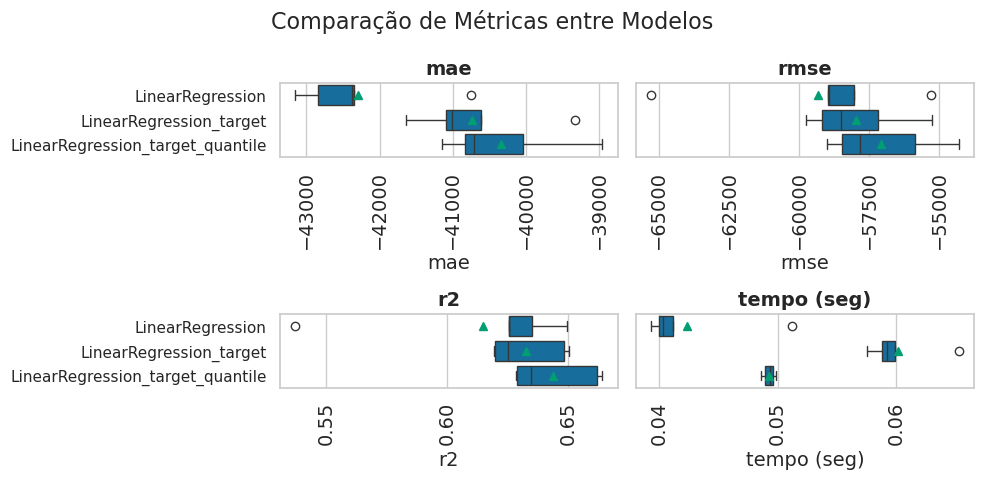

In [26]:
plot_comparar_metricas_modelos(
    df_resultados=df_resultados,
    comparar_metricas=['test_' + metrica for metrica in dct_metricas_modelos.keys()] + ['time_seconds'],
    nomes_metricas=list(dct_metricas_modelos.values()) + ['tempo (seg)'],
    figsize=(10, 5),
    colunas_graficos=2,
    flg_boxplots_horizontais=True,
)

### Sobre o novo modelo encontrado pelo GRID SEARCH
- O novo modelo com `QuantileTransformer(output_distribution='normal')` encontrado pelo GRID SEARCH se mostra superior em todas as métricas avaliadas.
- Vamos considerar esse novo modelo como substituto do `LinearRegression_target` que usava `PowerTransformer()`.

Novas análises ainda serão feitas nas próximas etapas. Ainda podemos transformar as features não categóricas, testar features polinomiais e regularização.

Vamos analisar resíduos para comparar com as próximas etapas.

## Resíduos do modelo novo

### Resíduos sobre a base de teste
Essa base não participou do treinamento em nenhum momento e são novos para o modelo.

In [27]:
df_residuos = pd.DataFrame()
df_residuos['residuos'] = y_test - grid_search.predict(X_test)

df_describe = fnc_describe_numericas_personalizado(
    df=df_residuos,
    flg_mostrar_dataframe=False,
    flg_retornar_dataframe=True,
    teste_normalidade='Kolmogorov-Smirnov'
)

df_describe[['dist_normal', 'pvalue', 'teste_normalidade', 'skewness', 'kurtosis',]].T

/dados/app/conda/envs/california/lib/python3.12/site-packages/pandas/core/dtypes/cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,residuos
dist_normal,False
pvalue,0
teste_normalidade,Kolmogorov-Smirnov
skewness,0.91
kurtosis,2.74


,min,LOWER,01%,25%,50%,75%,99%,UPPER,max,mean,std
residuos,-281418.312500,-115027.356394,-118079.143851,-29415.105469,-4537.274414,27659.729066,192083.616501,113271.980341,335366.394152,4060.005859,58145.431098


/tmp/ipykernel_10615/2052836030.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


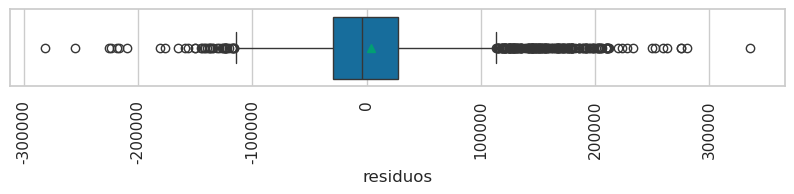

In [28]:
display(
    df_describe[['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean', 'std',
    ]].style.background_gradient(
        cmap=PALETTE_TEMPERATURA,
        axis='columns',
        subset=['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean',]
    )
)

# boxplot
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(
    data=df_residuos,
    x='residuos',
    showmeans=True,
    ax=ax,
)
# Definindo a orientação dos tick labels do eixo x na vertical
ax.set_xticklabels(
    labels=[int(x) for x in ax.get_xticks()],
    rotation=90,
)
plt.show()

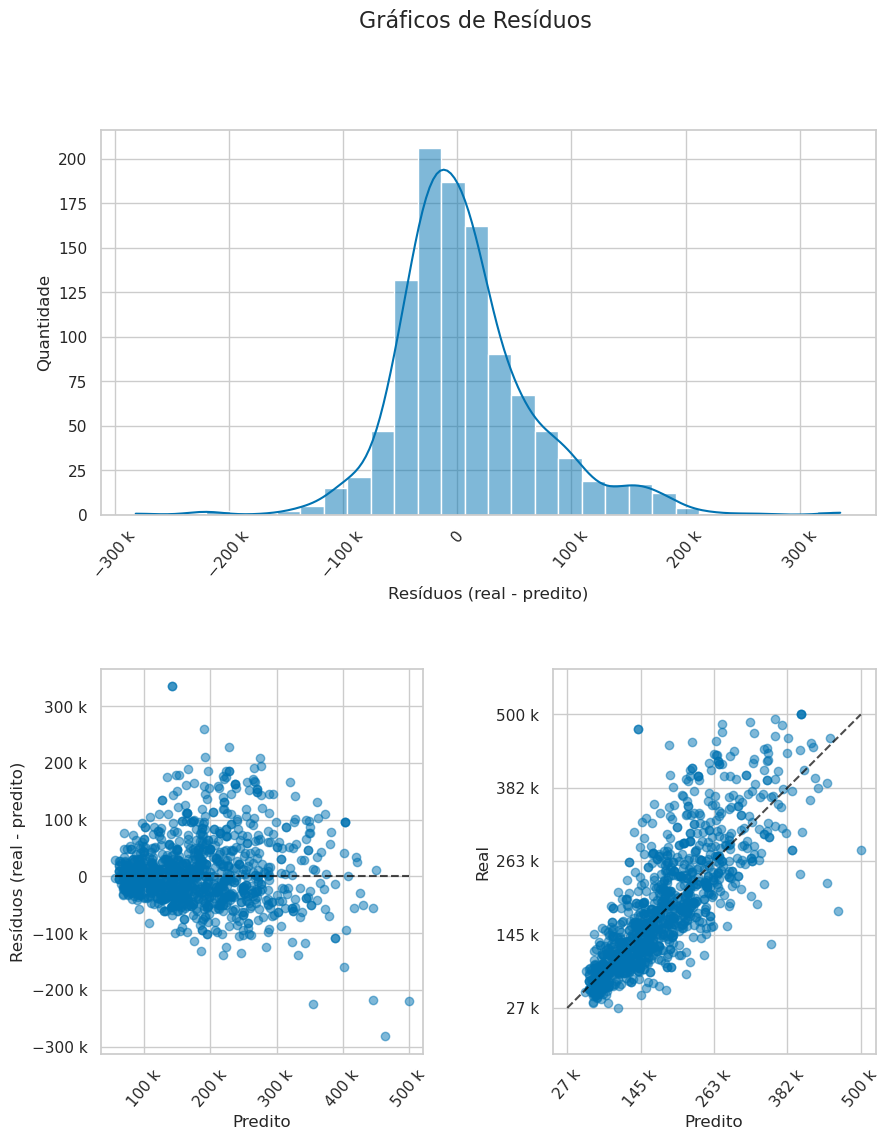

In [29]:
plot_residuos_estimador(grid_search.best_estimator_, X_test, y_test, fracao_amostra=0.3, eng_formatter=True) #, mosaico='bc;aa')

### Resíduos sobre a base de validação
Essa base não participou do treinamento em nenhum momento e são novos para o modelo.

In [30]:
df_residuos = pd.DataFrame()
df_residuos['residuos'] = y_validation - grid_search.predict(X_validation)

df_describe = fnc_describe_numericas_personalizado(
    df=df_residuos,
    flg_mostrar_dataframe=False,
    flg_retornar_dataframe=True,
    teste_normalidade='Kolmogorov-Smirnov'
)

df_describe[['dist_normal', 'pvalue', 'teste_normalidade', 'skewness', 'kurtosis',]].T

/dados/app/conda/envs/california/lib/python3.12/site-packages/pandas/core/dtypes/cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,residuos
dist_normal,False
pvalue,0
teste_normalidade,Kolmogorov-Smirnov
skewness,1.14
kurtosis,4.60


In [31]:
df_residuos = pd.DataFrame()
df_residuos['residuos'] = y_validation - grid_search.predict(X_validation)

df_describe = fnc_describe_numericas_personalizado(
    df=df_residuos,
    flg_mostrar_dataframe=False,
    flg_retornar_dataframe=True,
    teste_normalidade='Shapiro-Wilk'
)

df_describe[['dist_normal', 'pvalue', 'teste_normalidade', 'skewness', 'kurtosis',]].T

/dados/app/conda/envs/california/lib/python3.12/site-packages/pandas/core/dtypes/cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,residuos
dist_normal,False
pvalue,0
teste_normalidade,Shapiro-Wilk
skewness,1.14
kurtosis,4.60


,min,LOWER,01%,25%,50%,75%,99%,UPPER,max,mean,std
residuos,-337500,-118613.112396,-110027.912202,-30118.551343,-3643.368896,28877.822266,202609.948570,117372.383744,374384.647464,4520.706055,59866.144531


/tmp/ipykernel_10615/2052836030.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


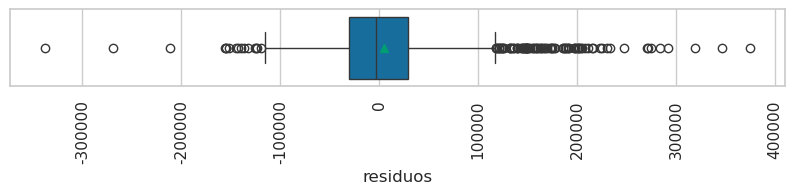

In [32]:
display(
    df_describe[['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean', 'std',
    ]].style.background_gradient(
        cmap=PALETTE_TEMPERATURA,
        axis='columns',
        subset=['min', 'LOWER', '01%', '25%', '50%', '75%', '99%', 'UPPER', 'max', 'mean',]
    )
)

# boxplot
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(
    data=df_residuos,
    x='residuos',
    showmeans=True,
    ax=ax,
)
# Definindo a orientação dos tick labels do eixo x na vertical
ax.set_xticklabels(
    labels=[int(x) for x in ax.get_xticks()],
    rotation=90,
)
plt.show()

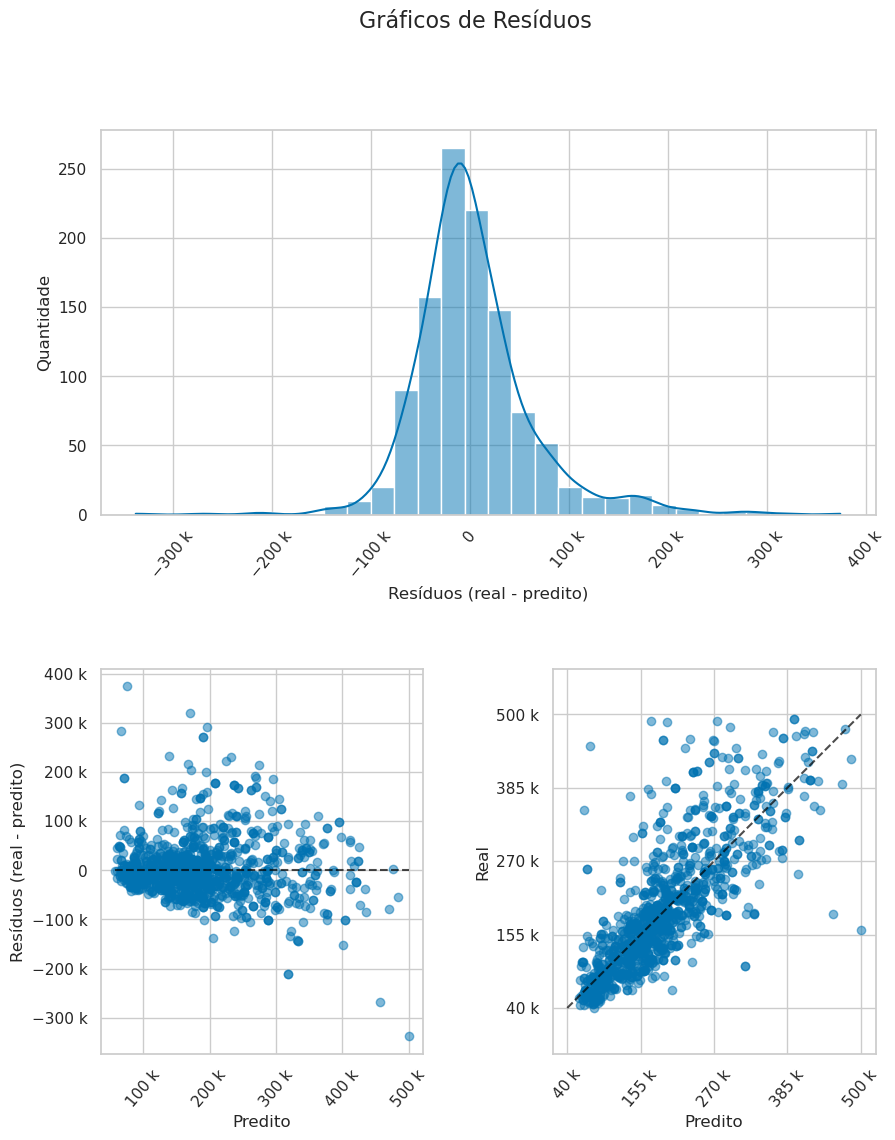

In [33]:
plot_residuos_estimador(grid_search.best_estimator_, X_validation, y_validation, fracao_amostra=0.6, eng_formatter=True) #, mosaico='bc;aa')


### Analisando os dados e gráficos de resíduos
- Vemos que os resíduos da base de teste comparado com os da base de validação tem números semelhantes.
- Considerando que na construção do modelo, não foram usados os registros da validação, o modelo pode ser considerado estável/válido.
- Os resíduos, estão em até 30 mil dólares para 50% das observações.
- Média e mediana estão próximos de zero.
- Temos sim alguns ouliers, mas de um modo geral os erros se ficam abaixo de 120 mil dólares, para baixo ou para cima.
- Nos dois casos temos a mesma tendencia dos resíduos.